In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import os
print(os.listdir("./EPA_DATA"))

['OZONE_AGG.csv', 'gases_aggregation.csv']


In [2]:
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors = 'coerce')
df = pd.read_csv("./EPA_DATA/gases_aggregation.csv", parse_dates=['year_month'], index_col='year_month', date_parser=dateparse) 
df.County_Name.unique()

array(['Adair', 'Adams', 'Allegheny', 'Anoka', 'BAJA CALIFORNIA NORTE',
       'Baltimore', 'Baltimore (City)', 'Beaver', 'Bergen', 'Berks',
       'Bexar', 'Blair', 'Blount', 'Boyd', 'Bronx', 'Broward', 'Bucks',
       'Camden', 'Charleston', 'Chittenden', 'Clark', 'Clay', 'Cook',
       'Cumberland', 'Cuyahoga', 'Dallas', 'Dauphin', 'Davidson', 'Davis',
       'DeKalb', 'Denver', 'Dona Ana', 'Duval', 'El Paso', 'Erie',
       'Essex', 'Fairfax', 'Fairfield', 'Fayette', 'Forsyth', 'Fresno',
       'Greenbrier', 'Hamilton', 'Hampden', 'Hampton City', 'Harris',
       'Hartford', 'Haywood', 'Hillsborough', 'Hudson', 'Imperial',
       'Jefferson', 'Kanawha', 'King', 'Lackawanna', 'Lancaster',
       'Los Angeles', 'Maricopa', 'Marion', 'Miami-Dade', 'Middlesex',
       'Milwaukee', 'Monroe', 'Montgomery', 'Morgan', 'Morris',
       'Multnomah', 'Nassau', 'New Castle', 'New Haven', 'New York',
       'Northampton', 'Oklahoma', 'Orange', 'Palm Beach', 'Philadelphia',
       'Pima', 'Pinel

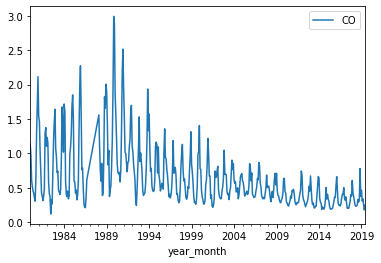

In [3]:
# df.index = pd.DatetimeIndex(df.index).to_period('M')

co_data = df[df.County_Name=='Sacramento'].sort_values(by=['year_month'])[['CO']]
co_data.index = pd.DatetimeIndex(co_data.index).to_period('M')
co_data.plot()
plt.show()

In [4]:
co_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 459 entries, 1980-01 to 2019-06
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      459 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


In [5]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16
pd.plotting.deregister_matplotlib_converters()

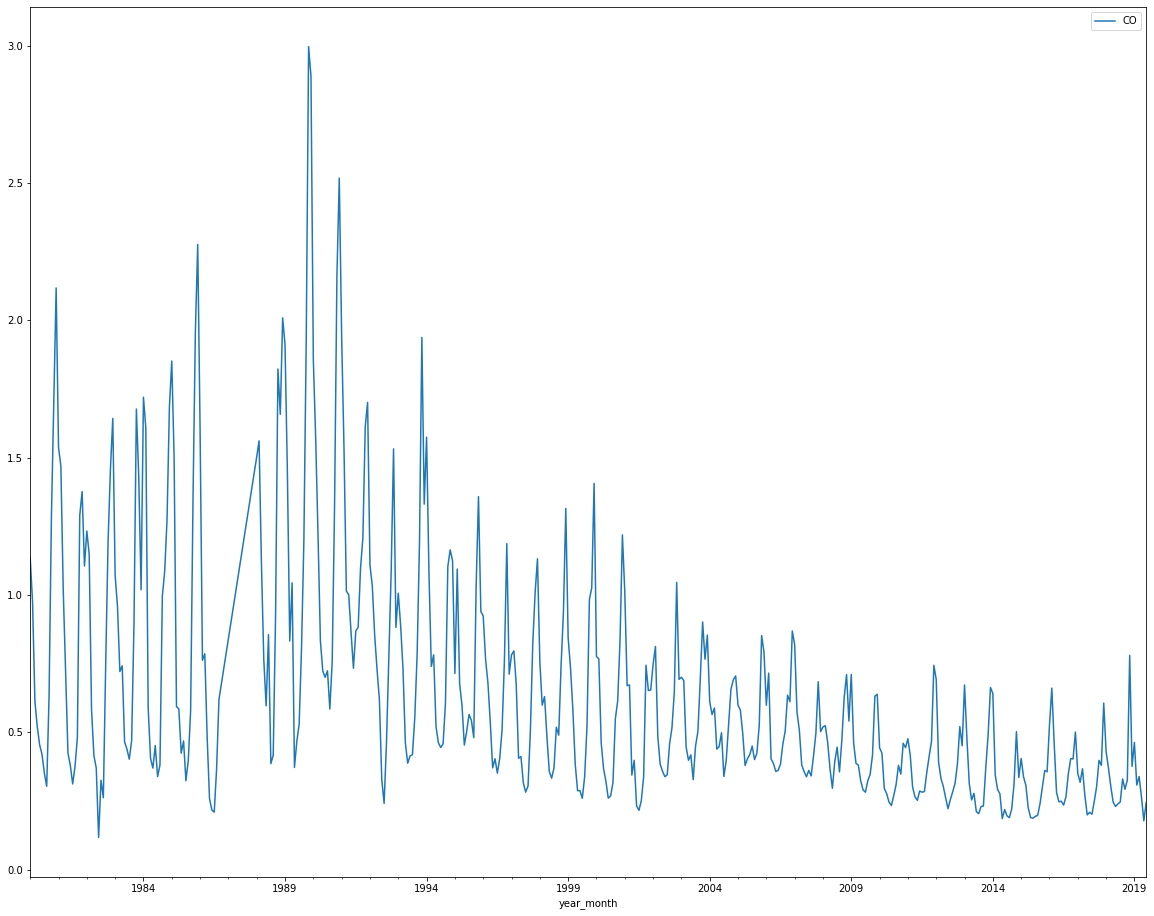

In [6]:
co_data.plot()
plt.show()

In [7]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    ts.plot(color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [8]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

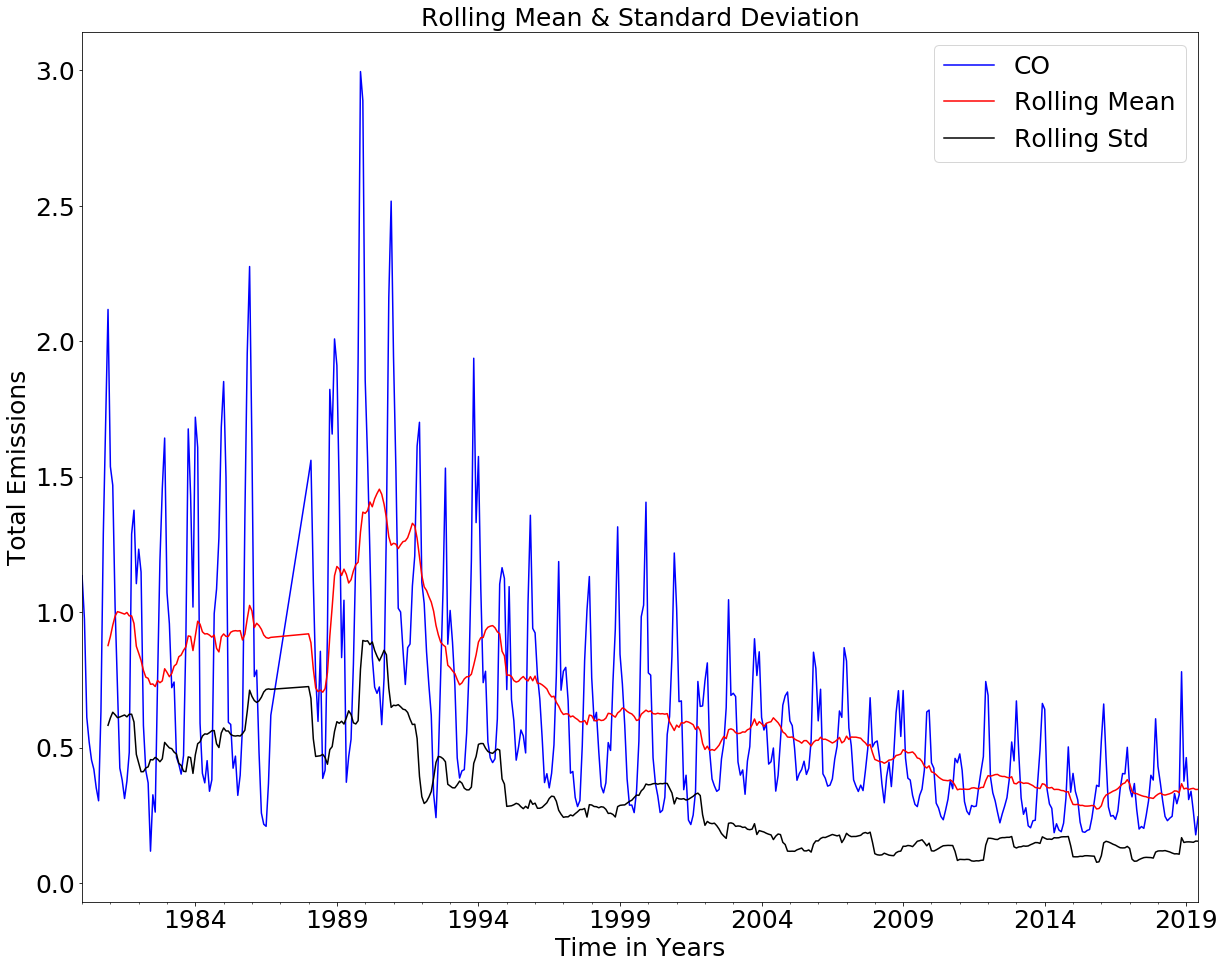

In [9]:
TestStationaryPlot(co_data)

In [10]:
TestStationaryAdfuller(co_data)

Test Statistic                  -1.616821
p-value                          0.474396
#Lags Used                      13.000000
Number of Observations Used    445.000000
Critical Value (1%)             -3.445131
Critical Value (5%)             -2.868057
Critical Value (10%)            -2.570241
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


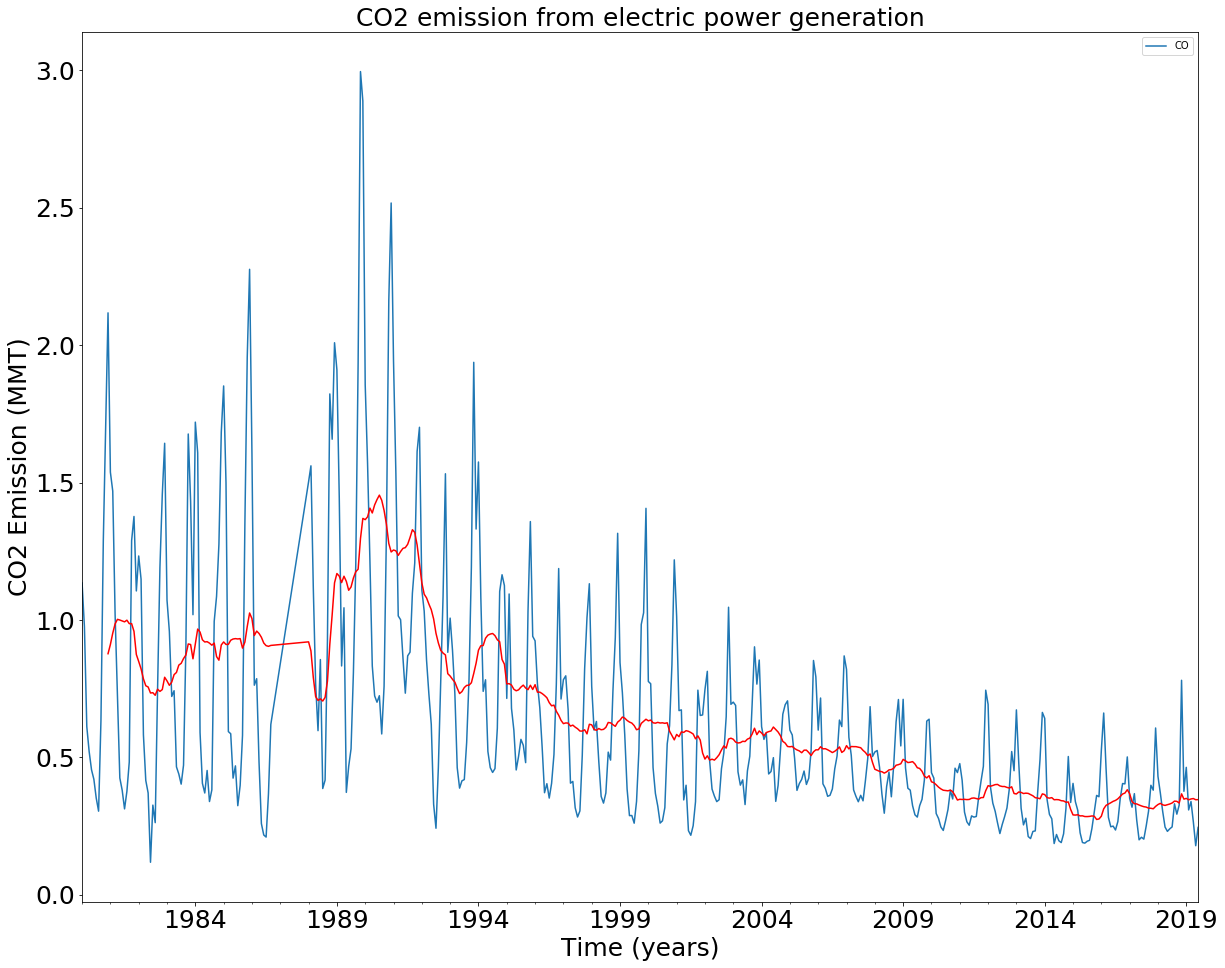

In [11]:
moving_avg = co_data.rolling(12).mean()
co_data.plot()
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Time (years)', fontsize = 25)
plt.ylabel('CO2 Emission (MMT)', fontsize = 25)
plt.title('CO2 emission from electric power generation', fontsize = 25)
plt.show()

In [12]:
mte_moving_avg_diff = co_data - moving_avg
mte_moving_avg_diff.head(13)

,CO
year_month,
1980-01,NaN
1980-02,NaN
1980-03,NaN
1980-04,NaN
1980-05,NaN
1980-06,NaN
1980-07,NaN
1980-08,NaN
1980-09,NaN


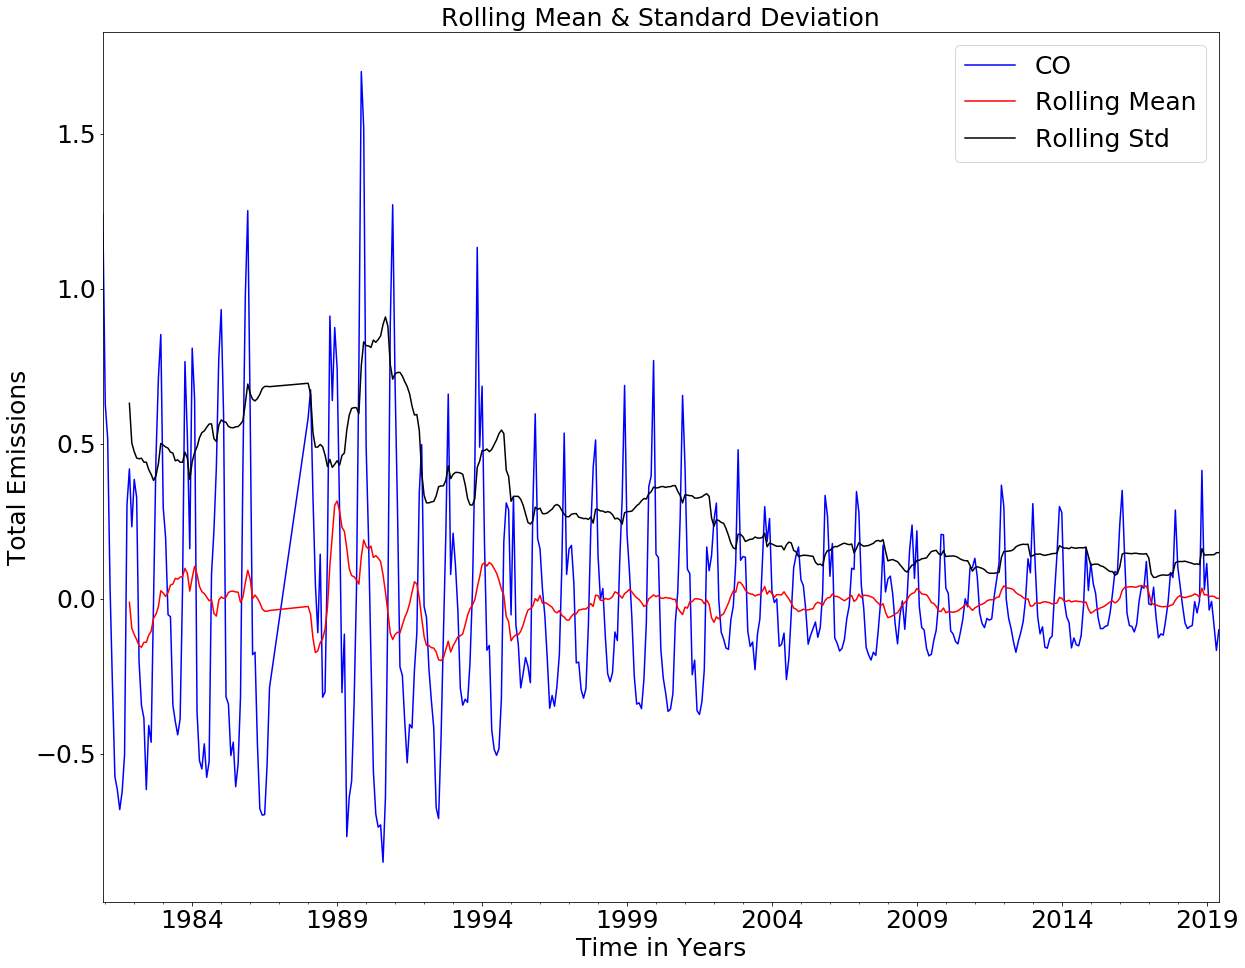

In [13]:
mte_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(mte_moving_avg_diff)

In [14]:
TestStationaryAdfuller(mte_moving_avg_diff)

Test Statistic                -6.764318e+00
p-value                        2.741646e-09
#Lags Used                     1.400000e+01
Number of Observations Used    4.330000e+02
Critical Value (1%)           -3.445543e+00
Critical Value (5%)           -2.868238e+00
Critical Value (10%)          -2.570338e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


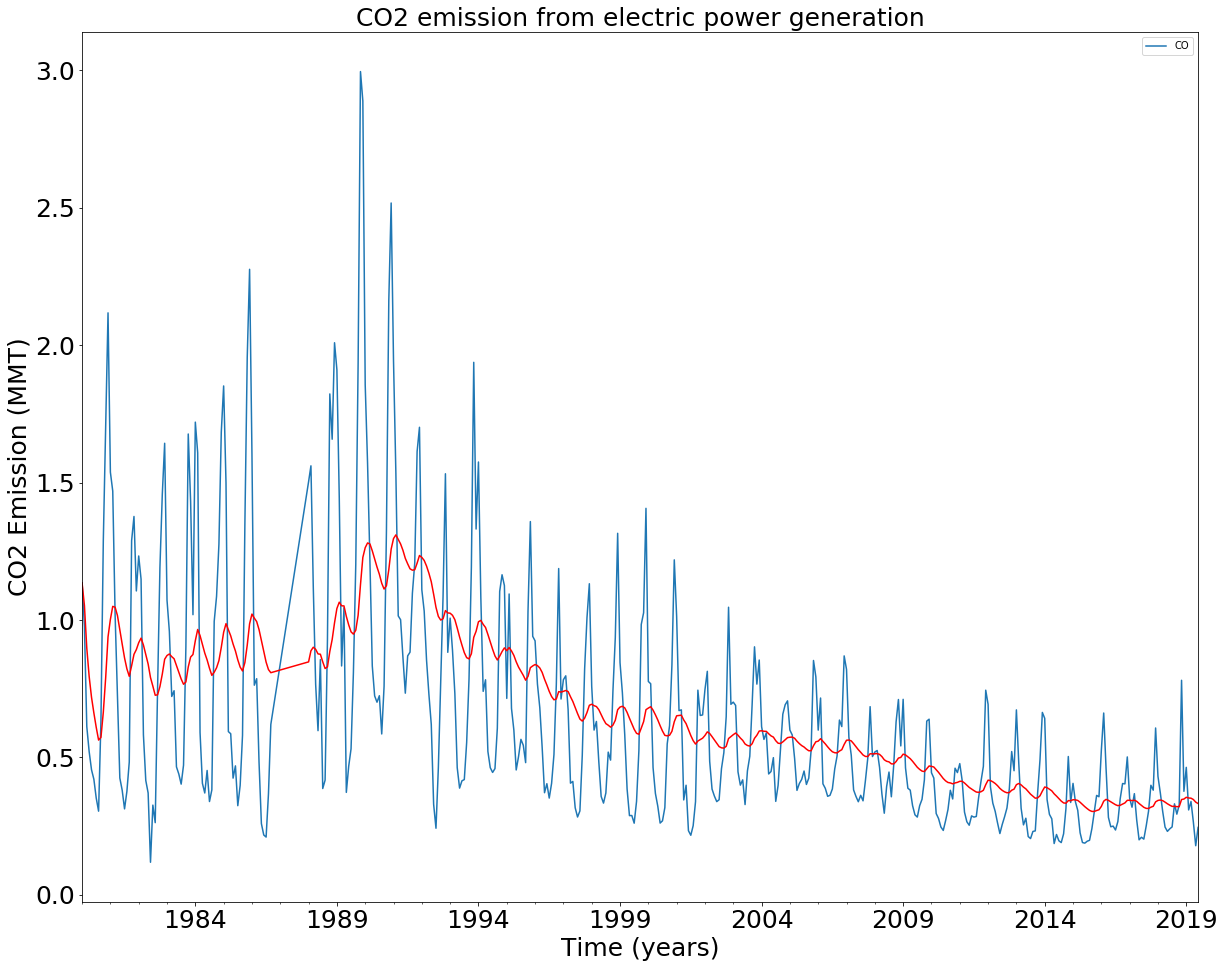

In [15]:
mte_exp_wighted_avg = co_data.ewm(halflife=12).mean()
co_data.plot()
plt.plot(mte_exp_wighted_avg, color='red')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Time (years)', fontsize = 25)
plt.ylabel('CO2 Emission (MMT)', fontsize = 25)
plt.title('CO2 emission from electric power generation', fontsize = 25)
plt.show()

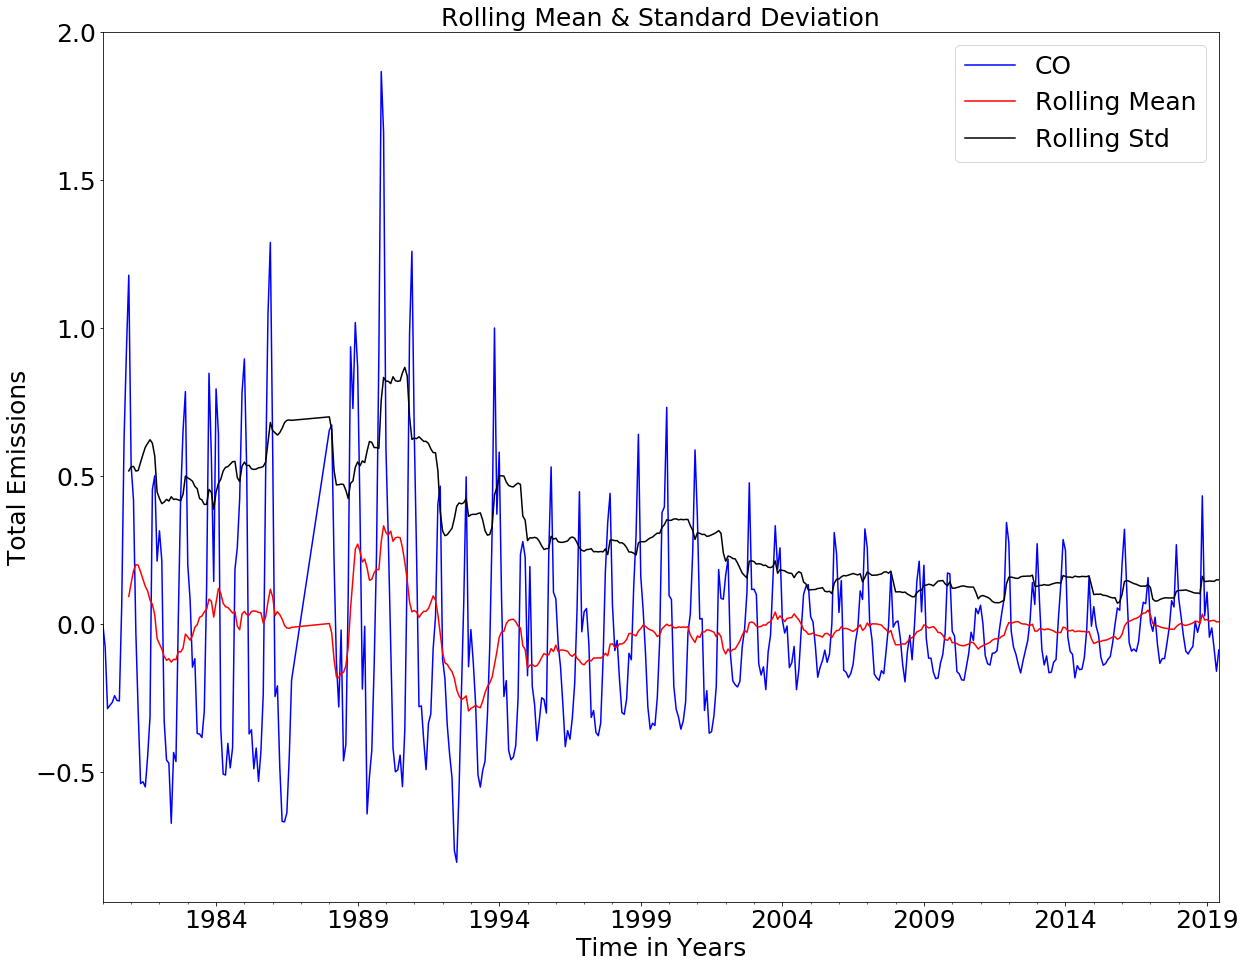

In [16]:
mte_ewma_diff = co_data - mte_exp_wighted_avg
TestStationaryPlot(mte_ewma_diff)

In [17]:
TestStationaryAdfuller(mte_ewma_diff)

Test Statistic                  -4.692759
p-value                          0.000087
#Lags Used                      13.000000
Number of Observations Used    445.000000
Critical Value (1%)             -3.445131
Critical Value (5%)             -2.868057
Critical Value (10%)            -2.570241
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


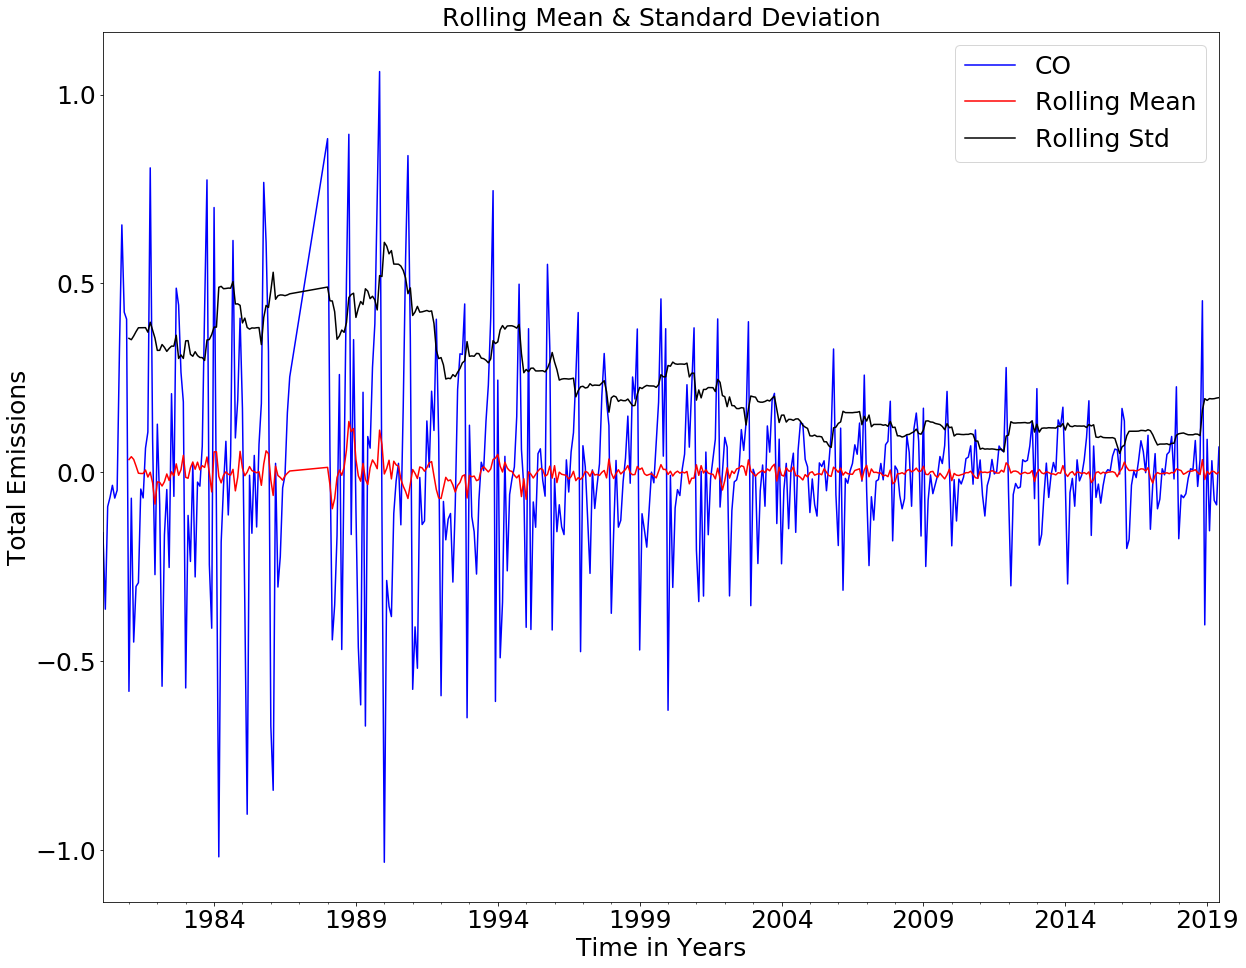

In [18]:
mte_first_difference = co_data - co_data.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [19]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

Test Statistic                -9.659615e+00
p-value                        1.364608e-16
#Lags Used                     1.200000e+01
Number of Observations Used    4.450000e+02
Critical Value (1%)           -3.445131e+00
Critical Value (5%)           -2.868057e+00
Critical Value (10%)          -2.570241e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


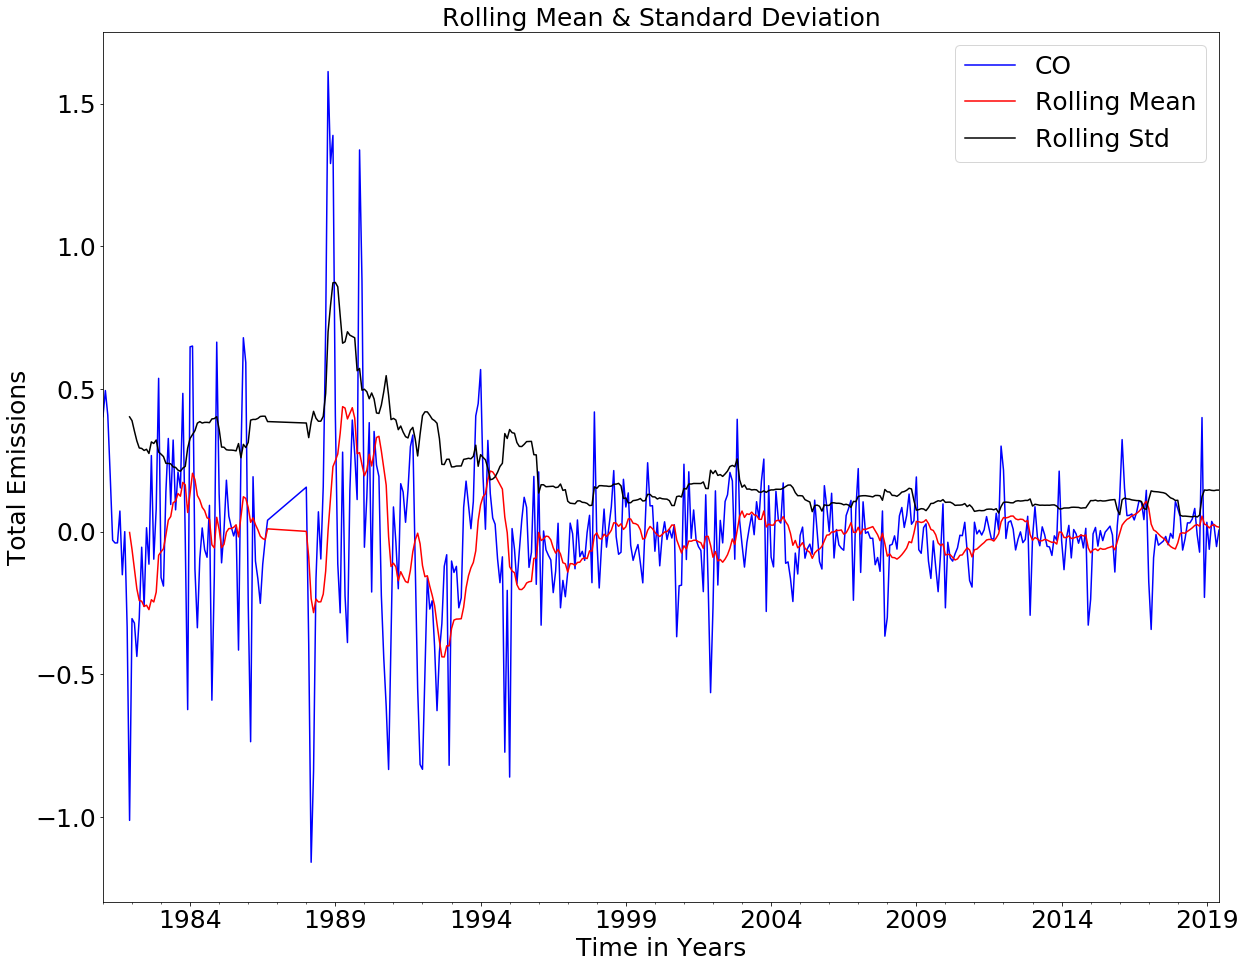

Test Statistic                  -5.412866
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    433.000000
Critical Value (1%)             -3.445543
Critical Value (5%)             -2.868238
Critical Value (10%)            -2.570338
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [20]:
mte_seasonal_difference = co_data - co_data.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

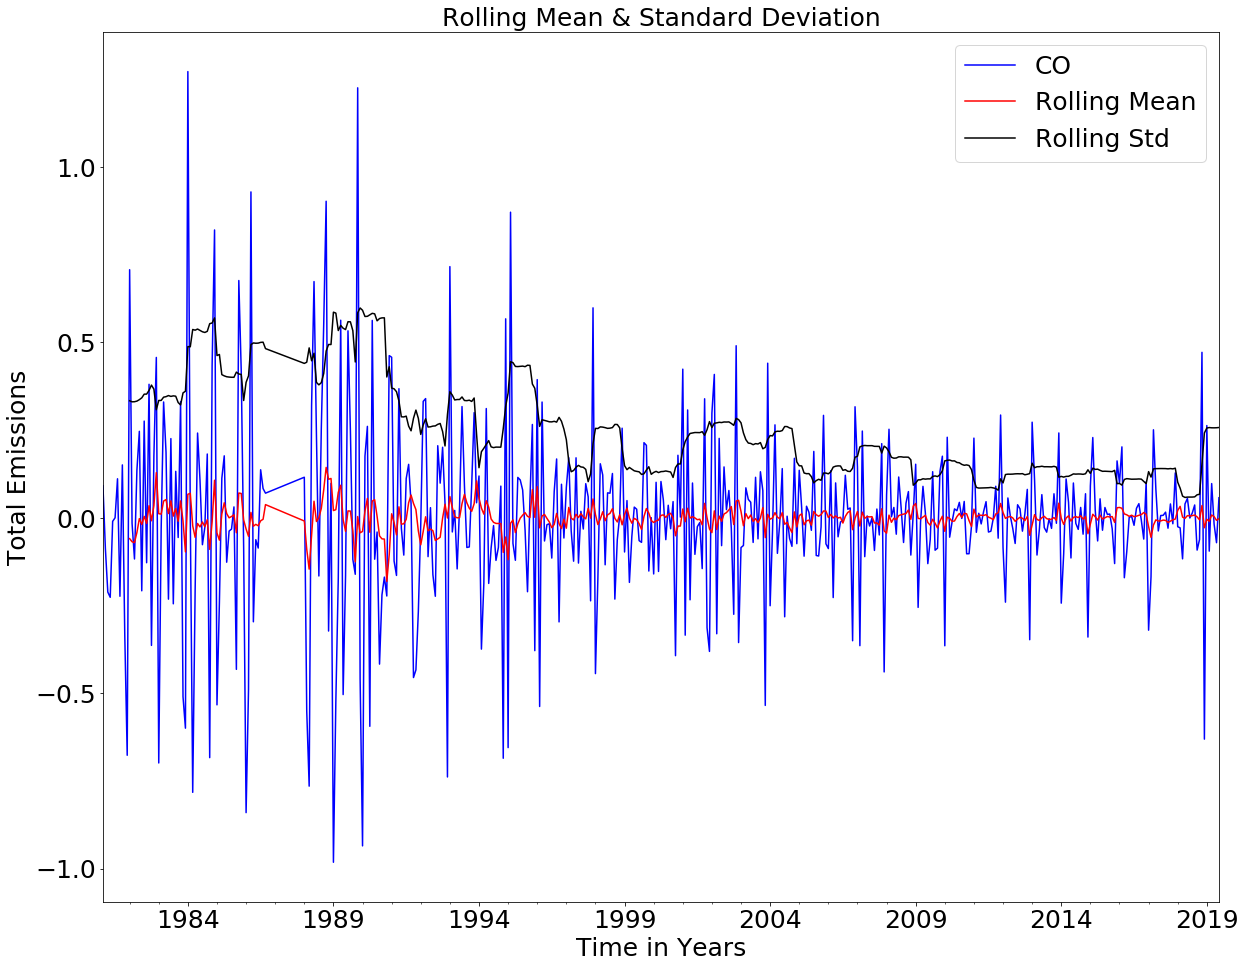

In [21]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))

In [22]:
TestStationaryAdfuller(mte_seasonal_first_difference.dropna(inplace=False))

Test Statistic                -1.091675e+01
p-value                        1.062735e-19
#Lags Used                     1.100000e+01
Number of Observations Used    4.340000e+02
Critical Value (1%)           -3.445508e+00
Critical Value (5%)           -2.868223e+00
Critical Value (10%)          -2.570330e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [23]:
co_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 459 entries, 1980-01 to 2019-06
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      459 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


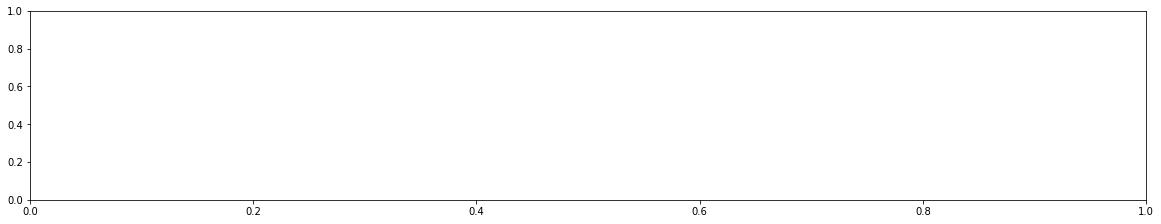

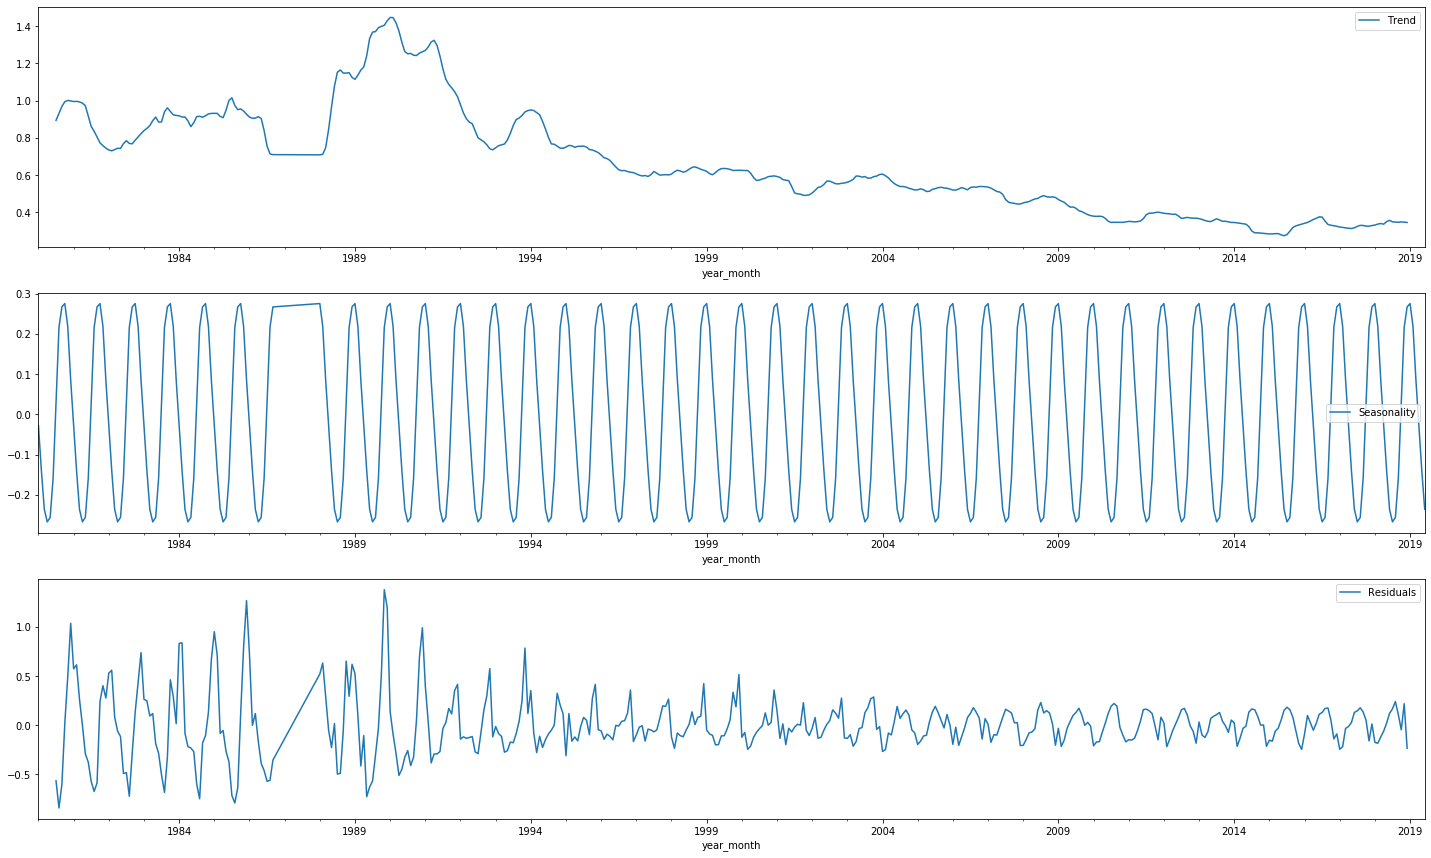

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(co_data, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
co_data.plot(label='Original')
plt.legend(loc='best')
plt.subplot(412)
trend.plot(label='Trend')
plt.legend(loc='best')
plt.subplot(413)
seasonal.plot(label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
residual.plot( label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

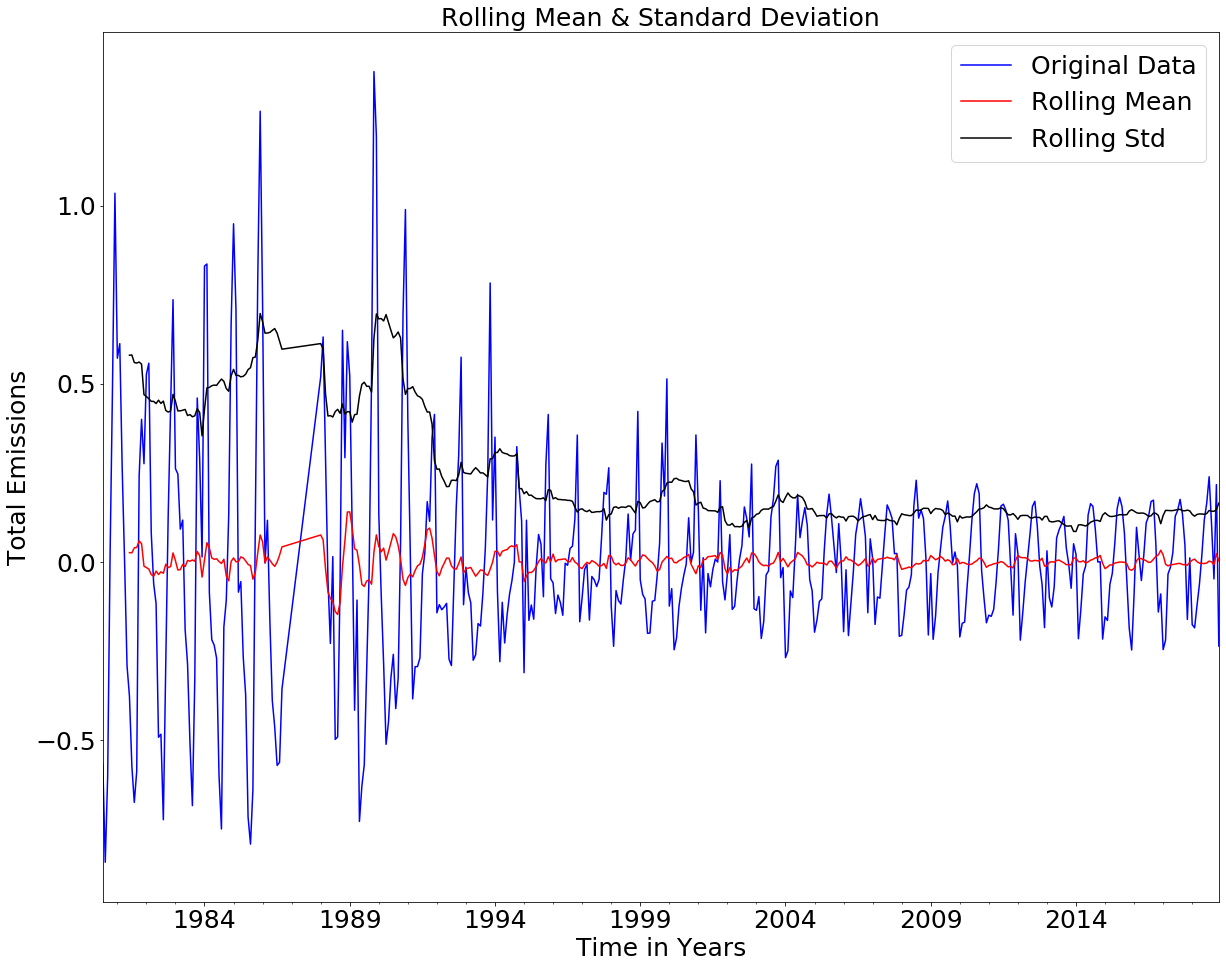

Test Statistic                -1.010330e+01
p-value                        1.045701e-17
#Lags Used                     1.800000e+01
Number of Observations Used    4.280000e+02
Critical Value (1%)           -3.445721e+00
Critical Value (5%)           -2.868317e+00
Critical Value (10%)          -2.570380e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [25]:
mte_decompose = residual
mte_decompose.dropna(inplace=True)
TestStationaryPlot(mte_decompose)
TestStationaryAdfuller(mte_decompose)

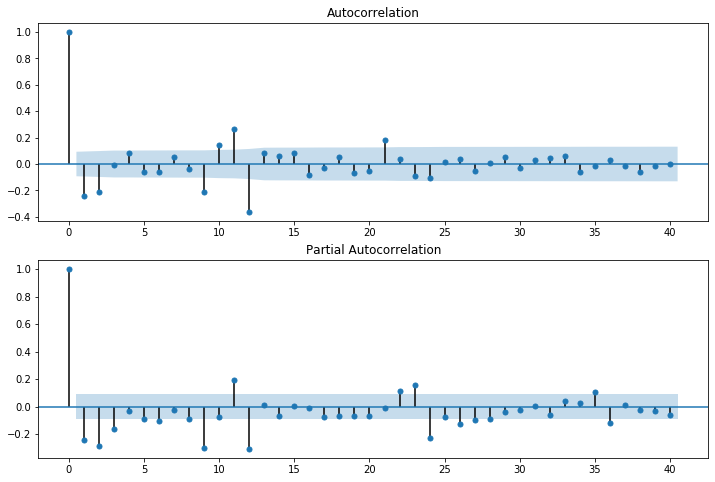

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [27]:
import itertools

p = d = q = range(0, 3) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 2) x (0, 0, 2, 12)


In [28]:
mod = sm.tsa.statespace.SARIMAX(co_data, 
                                order=(2,1,2), 
                                seasonal_order=(2,1,2,12),   
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

/anaconda3/envs/hw-1/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                 CO   No. Observations:                  459
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                  64.027
Date:                            Sun, 29 Mar 2020   AIC                           -110.055
Time:                                    17:49:17   BIC                            -73.152
Sample:                                01-31-1980   HQIC                           -95.505
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4245      0.065     21.764      0.000       1.296       1.553
ar.L2         -0.6153      0.039   

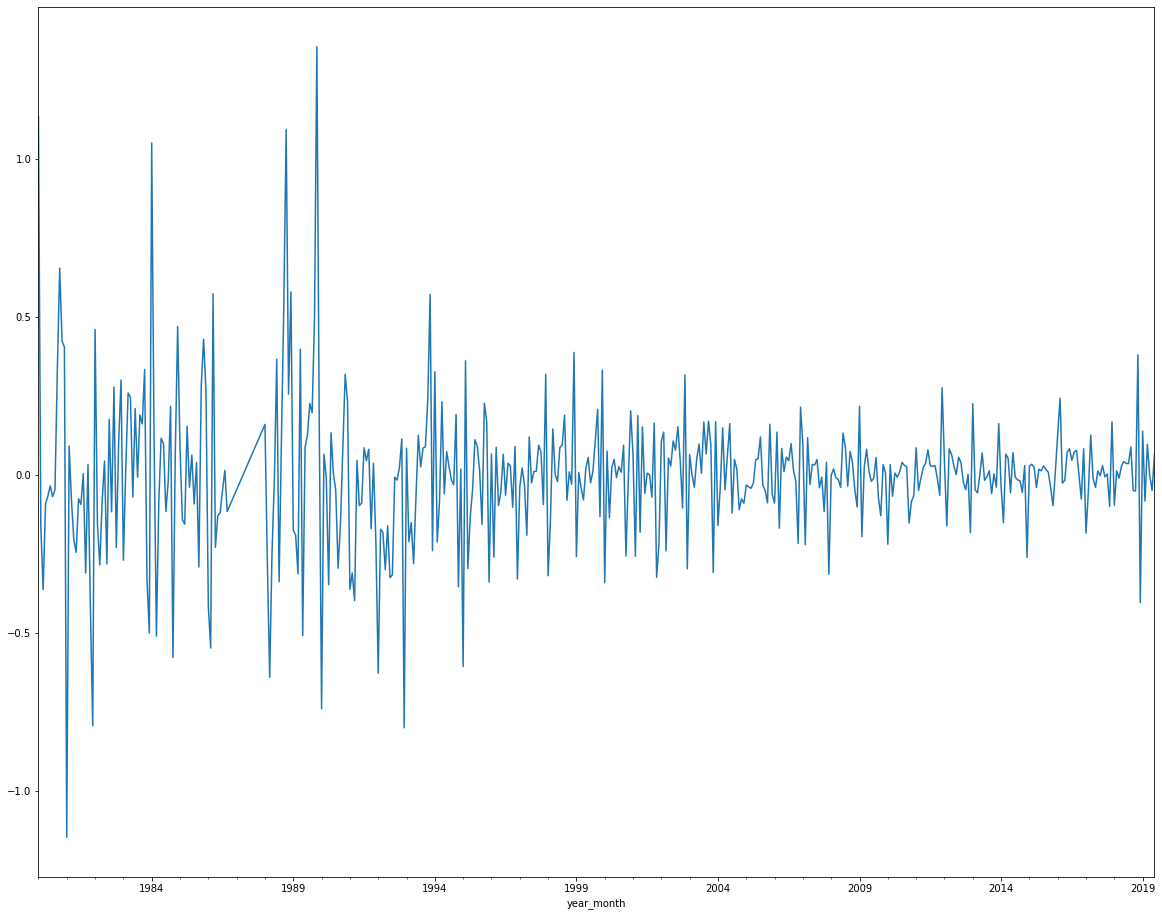

In [29]:
results.resid.plot()

In [30]:
print(results.resid.describe())

count    459.000000
mean      -0.002426
std        0.228325
min       -1.147334
25%       -0.087202
50%        0.006136
75%        0.084491
max        1.356145
dtype: float64


In [35]:
pred = results.get_prediction(start = '2015',end='2030', dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower CO,upper CO
2013-10,-0.026595,0.781272
2013-11,-0.099701,0.708166
2013-12,-0.121612,0.686255
2014-01,-0.139104,0.668762
2014-02,-0.232504,0.575358


/anaconda3/envs/hw-1/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


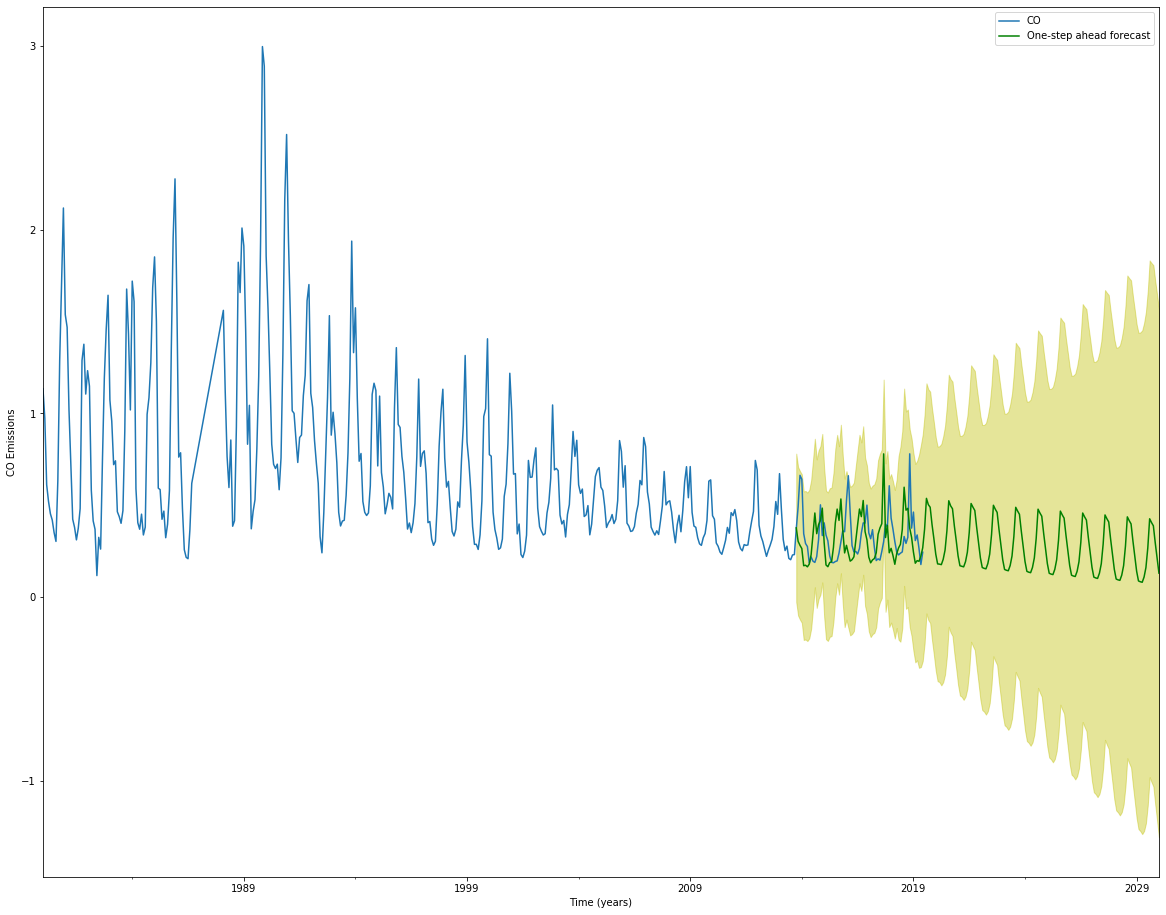

In [37]:
ax = co_data.plot(label='observed')
pred.predicted_mean.plot( label='One-step ahead forecast', alpha=1,color='G')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='y', alpha=.4)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO Emissions')
plt.legend()

plt.show()

In [33]:
# forecast = results.get_forecast(start='2019', dynamic=True, full_results=True)
forecast = results.get_forecast(steps=200)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.tail()

,lower CO,upper CO
2034-07,-1.681880,2.113668
2034-08,-1.530987,2.280362
2034-09,-1.558876,2.267270
2034-10,-1.583788,2.256829
2034-11,-1.683173,2.172045


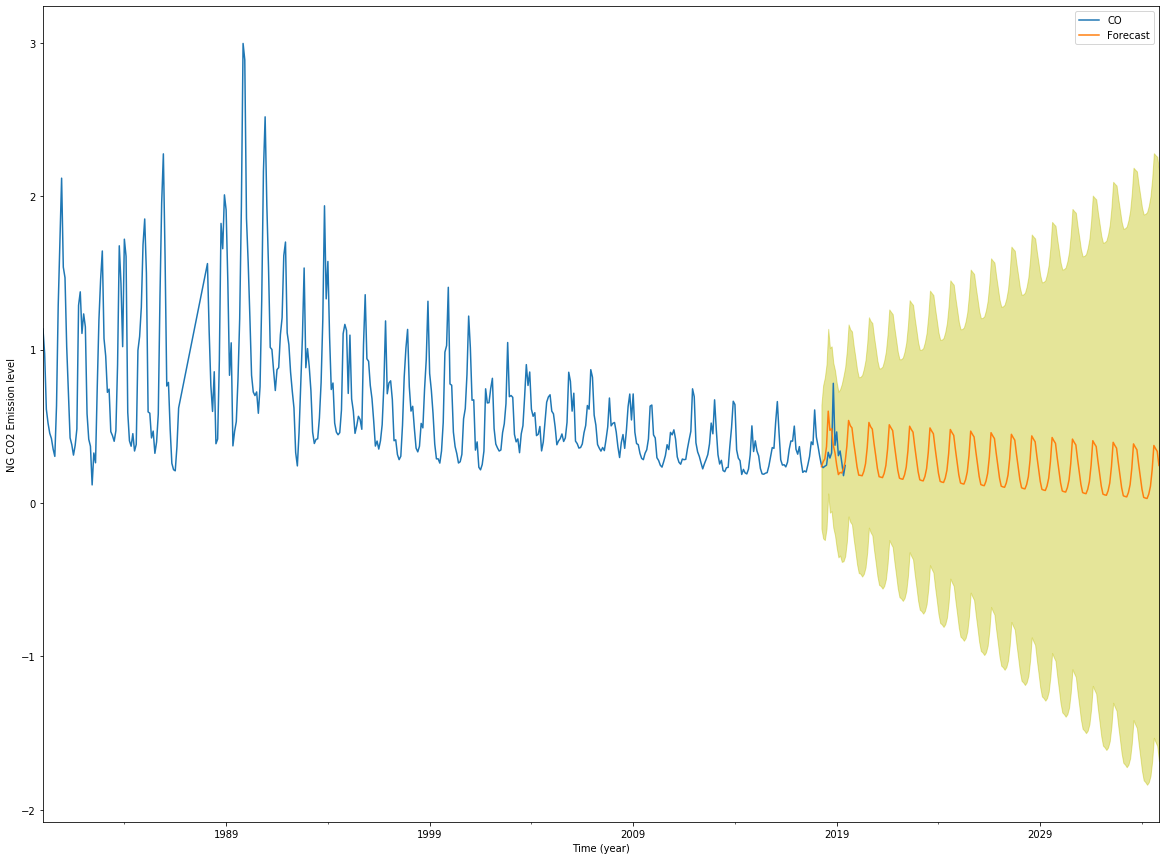

In [34]:
ax = co_data.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='y', alpha=.4)
ax.set_xlabel('Time (year)')
ax.set_ylabel('NG CO2 Emission level')

plt.legend()
plt.show()